## Reload the `EC_estimator.py` code to consider any changes

In [5]:
#reload model magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import EC_estimator as annx2

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import X2_estimator as annx2
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [8]:
tf.__version__

'2.2.0'

In [13]:
def create_antecedent_inputs_ordered(
    df_inputs: pd.DataFrame,
    ndays: int = 8,          # will create 1d..7d (since 0d is the original column)
    window_size: int = 11,
    nwindows: int = 10,      # will create 1ave..10ave
    predictors_order=None,
    date_col: str = "date",
):
    
    # --- set predictor order
    if predictors_order is None:
        predictors_order = df_inputs.columns.tolist()

    # --- require DatetimeIndex for the time-based rolling/shifts
    if not isinstance(df_inputs.index, pd.DatetimeIndex):
        raise ValueError("df_inputs must have a DatetimeIndex (set date as index first).")

    df_inputs = df_inputs.sort_index()

    out = pd.DataFrame(index=df_inputs.index)

    # 1) date column first (as a column, not index)
    out[date_col] = df_inputs.index

    # 2) original predictors next
    for p in predictors_order:
        out[p] = df_inputs[p]

    # 3) daily antecedents grouped by lag: 1d..(ndays-1)d
    for d in range(1, ndays):
        for p in predictors_order:
            out[f"{p}_{d}d"] = df_inputs[p].shift(d)

    # 4) rolling averages grouped by window number: 1ave..nwindows_ave
    # Rolling mean over a time window (requires daily-ish datetime index)
    for p in predictors_order:
        out[f"__tmp_ma__{p}"] = df_inputs[p].rolling(f"{window_size}D", min_periods=window_size).mean()

    for k in range(1, nwindows + 1):
        shift_days = ndays + window_size * (k - 1)
        for p in predictors_order:
            out[f"{p}_{k}ave"] = out[f"__tmp_ma__{p}"].shift(shift_days, freq="D")

    # remove temp columns
    out = out.drop(columns=[f"__tmp_ma__{p}" for p in predictors_order])

    # drop rows that are incomplete due to shifting/rolling
    out = out.dropna().reset_index(drop=True)

    return out


In [19]:
import os

# project root = folder that CONTAINS "Inputs"
os.chdir(r"E:\ANN-Phase-II\cs3-surrogate-training")

print("CWD:", os.getcwd())
print("Inputs contents:", os.listdir("Inputs"))


CWD: E:\ANN-Phase-II\cs3-surrogate-training
Inputs contents: ['inputs.csv', 'selected.csv', 'x2_data_in.csv', 'x2_data_out.csv', 'x2_inputs_antecedents_ordered.csv', 'x2_inputs_antecedents_ordered_with_output.csv']


In [20]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

in_path = './Inputs/x2_data_in.csv'
df = pd.read_csv(in_path)

# parse/sort/index
df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date").set_index("date")

predictors = ["NDOI", "SMSCG", "Tide"]
y_col = "X_2_DIS"

# X for antecedents (no output inside)
X = df[predictors].copy()

ante = create_antecedent_inputs_ordered(
    X,
    ndays=8,
    window_size=11,
    nwindows=10,
    predictors_order=predictors,
    date_col="date",
)

# --- add output as last column by matching date
# 'ante' currently has a 'date' column (not index), so merge on that
y = df[[y_col]].reset_index()  # columns: date, X_2_DIS
ante = ante.merge(y, on="date", how="left")

# (optional) sanity check: make sure nothing is missing
missing_y = ante[y_col].isna().sum()
if missing_y:
    raise ValueError(f"{missing_y} rows have missing {y_col} after merge. Check date alignment.")

# write
out_path = "./Inputs/x2_inputs_antecedents_ordered_with_output.csv"
ante.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: ./Inputs/x2_inputs_antecedents_ordered_with_output.csv


## Load the dataset, preprocessing, and apply ANN model

In [9]:
# Load data
df = annx2.load_data("Inputs/x2_inputs_antecedents_ordered_with_output.csv")
# Parse real dates
df["date"] = pd.to_datetime(df["date"], errors="raise")

# Sort and set REAL date index
df = df.sort_values("date").set_index("date")

# Remove date from columns so it is NOT treated as a feature
df = df.drop(columns=["date"], errors="ignore")

# Now create (var, lag) MultiIndex columns
df_var = annx2.df_by_variable(df)

# Split by date ranges: 1923-1939 for test, 1940-2015 for training
# Ensure index is datetime
if not isinstance(df_var.index, pd.DatetimeIndex):
    df_var.index = pd.to_datetime(df_var.index, errors="raise")

df_var = df_var.sort_index()

# Split data by year: 1923-1939 for test, 1940-2015 for training
df_test = df_var[(df_var.index.year >= 1923) & (df_var.index.year <= 1939)]
df_train_full = df_var[(df_var.index.year >= 1940) & (df_var.index.year <= 2015)]

# Further split training data: 80% for training (calibration), 20% for validation
# Using random masks approach similar to annutilsr
calib_prop = 0.8  # 80% of the data for calibration
vset = np.random.rand(df_train_full.shape[0])
train_mask = vset < calib_prop
val_mask = (vset >= calib_prop) & (vset < (calib_prop + 0.2))

df_train = df_train_full[train_mask]
df_val = df_train_full[val_mask]

# Optional sanity checks
if df_test.empty:
    raise ValueError("df_test is empty. Check that the index is datetime and dates exist in 1923–1939.")
if df_train.empty:
    raise ValueError("df_train is empty. Check that the index is datetime and dates exist in 1940–2015.")

print("Train:", df_train.index.min().date(), "→", df_train.index.max().date(), "rows:", len(df_train))
print("Val  :", df_val.index.min().date(),   "→", df_val.index.max().date(),   "rows:", len(df_val))
print("Test :", df_test.index.min().date(),  "→", df_test.index.max().date(),  "rows:", len(df_test))

# Build model inputs
inputs = annx2.build_model_inputs(df_var)

# Preprocessing layers
layers = annx2.preprocessing_layers(df_var, inputs)

# Build model
neurons = [8, 2, 1]  # This is an example; adapt it to your needs
activations = ['sigmoid', 'sigmoid']
model, tensorboard_cb = annx2.build_model(layers, inputs)

# Extract training features and target
X_train = [df_train.loc[:, pd.IndexSlice[feature, annx2.lags_feature[feature]]] for feature in annx2.feature_names()]

target = "X_2_DIS"

y_train = df_train.loc[:, pd.IndexSlice[target, :]].iloc[:, 0].to_frame(name=target)
y_train.columns = ["X_2_DIS"]

# Extract validation features and target
X_val = [df_val.loc[:, pd.IndexSlice[feature, annx2.lags_feature[feature]]] for feature in annx2.feature_names()]

y_val = df_val.loc[:, pd.IndexSlice[target, :]].iloc[:, 0].to_frame(name=target)
y_val.columns = ["X_2_DIS"]

# Extract test features and target
X_test = [df_test.loc[:, pd.IndexSlice[feature, annx2.lags_feature[feature]]] for feature in annx2.feature_names()]

y_test = df_test.loc[:, pd.IndexSlice[target, :]].iloc[:, 0].to_frame(name=target)
y_test.columns = ["X_2_DIS"]

# Train model with validation data
history, model = annx2.train_model(model, tensorboard_cb, X_train, y_train, X_val, y_val)

Train: 1940-01-01 → 2015-09-30 rows: 22178
Val  : 1940-01-04 → 2015-09-24 rows: 5489
Test : 1923-04-28 → 1939-12-31 rows: 6092


## Illustration of by-variable input (df_var)

In [ ]:
df = annx2.load_data('Inputs/inputs.csv')

# This will break up the incoming DataFrame into a MultiIndex column
# with the site/variable (e.g. Sac) as the 0-level index and
# lag (e.g. '3d') as the fast index.
df_var = annx2.df_by_variable(df)

# This is an illustration of how to extract a single location/variable
# so that it (with its lags) can be used as a single input in the ANN. 
# In the traditional CalSIM model would be 18 values 
# The droplevel gets rid of the vestiges of the multiindex
sac = df_var.loc[:, pd.IndexSlice['sac',:]].droplevel(level="var",axis=1)
print(sac.head(4))





## Evaluation of the model

In [15]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("predictions")
print(y_train_pred[-4:-1])
print(y_test_pred[-4:-1])
print("input data")
print(X_train[0].iloc[-4:-1])
print(X_test[0].iloc[-4:-1])
print("end predictions")
metrics.append(annx2.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)

#print(tabulate(df3, headers='keys', tablefmt='psql'))



predictions
[[91.89074 ]
 [92.138725]
 [92.58534 ]]
[[85.50688]
 [84.44479]
 [82.98126]]
input data
var           NDOI                                                          \
lag             0d      1d      2d      3d      4d      5d      6d      7d   
date                                                                         
2015-09-27  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0   
2015-09-28  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0   
2015-09-29  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0   

var                                                                        \
lag           1ave    2ave    3ave         4ave         5ave         6ave   
date                                                                        
2015-09-27  3000.0  3000.0  3000.0  3031.523225  3283.035781  3737.305437   
2015-09-28  3000.0  3000.0  3000.0  3022.308854  3249.877965  3690.996572   
2015-09-29  3000.0  3000.0  3000.0  3015.05269

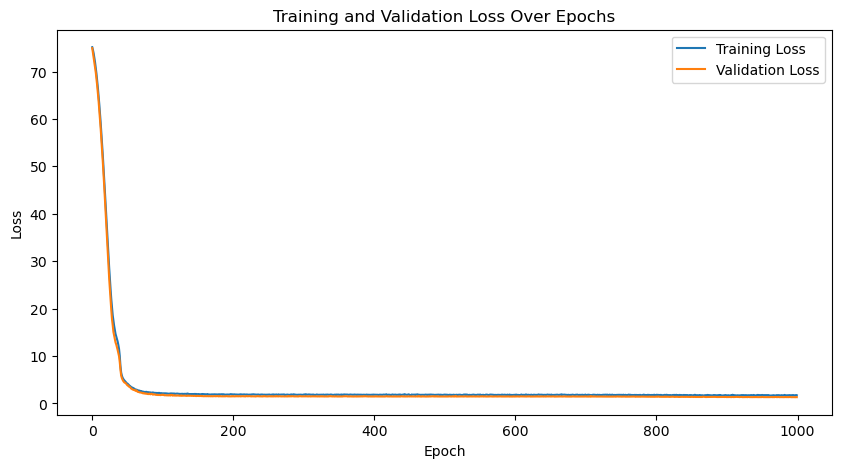

In [10]:
annx2.plot_history(history)

## Plot the ANN prediction versus the test target as a time series

0    81.59832
Name: 1939-12-31 00:00:00, dtype: float32


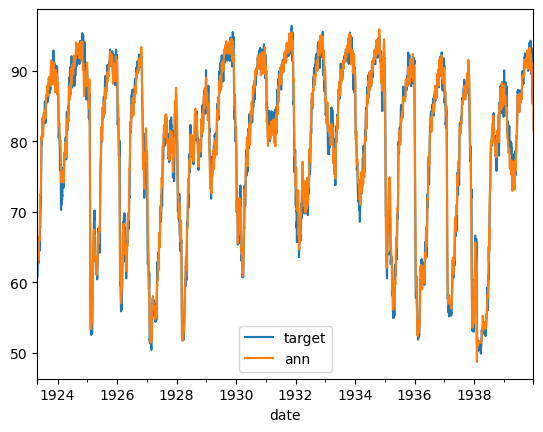

In [16]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

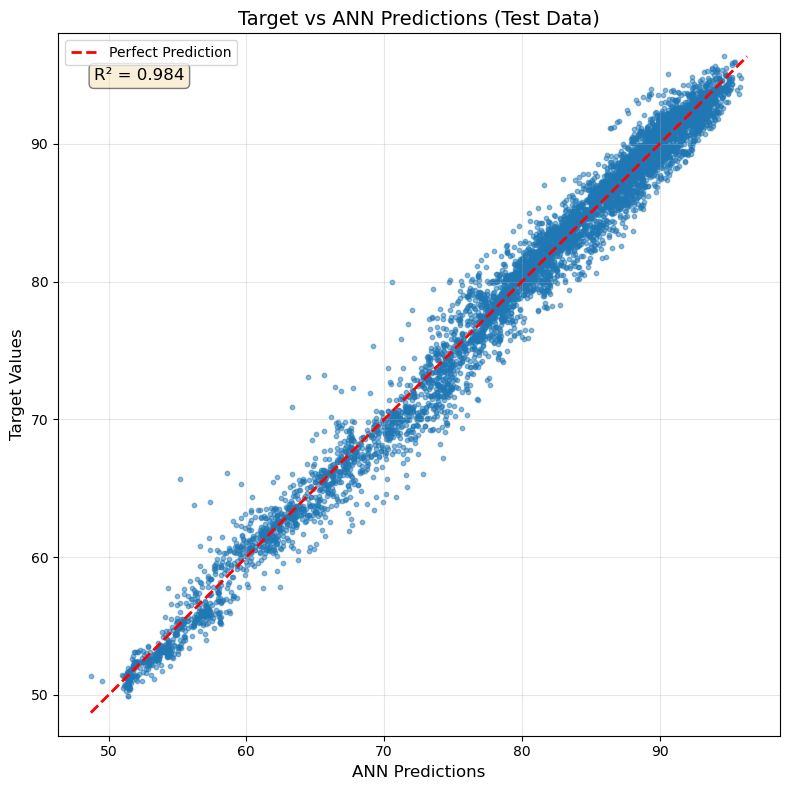

In [20]:
## Target vs ANN predictions scatter plot (Test Data)

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for test data
y_test_np = y_test.values.ravel()
y_test_pred_np = y_test_pred.ravel()
r2_test = r2_score(y_test_np, y_test_pred_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_pred_np, y_test_np, alpha=0.5, s=10)

# Add diagonal line (perfect prediction)
min_val = min(y_test_np.min(), y_test_pred_np.min())
max_val = max(y_test_np.max(), y_test_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_test:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions', fontsize=12)
plt.ylabel('Target Values', fontsize=12)
plt.title('Target vs ANN Predictions (Test Data)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

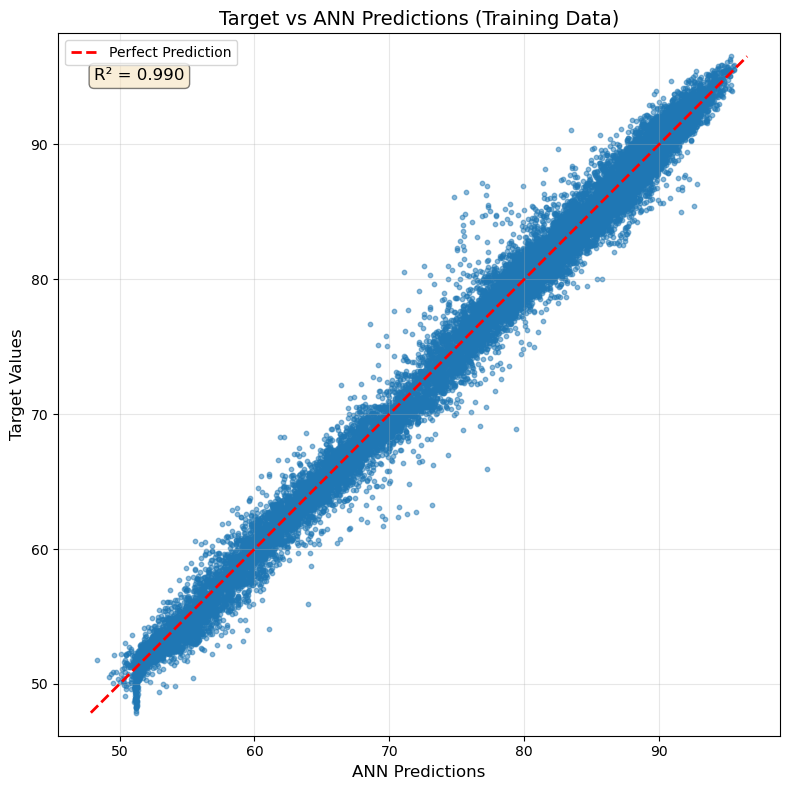

In [21]:
## Target vs ANN predictions scatter plot (Training Data)

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for training data
y_train_np = y_train.values.ravel()
y_train_pred_np = y_train_pred.ravel()
r2_train = r2_score(y_train_np, y_train_pred_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train_pred_np, y_train_np, alpha=0.5, s=10)

# Add diagonal line (perfect prediction)
min_val = min(y_train_np.min(), y_train_pred_np.min())
max_val = max(y_train_np.max(), y_train_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_train:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions', fontsize=12)
plt.ylabel('Target Values', fontsize=12)
plt.title('Target vs ANN Predictions (Training Data)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [23]:
## Monthly averages: resample predictions and target data

# Resample to monthly averages for training data
y_train_monthly = y_train.resample('MS').mean()
y_train_pred_monthly = pd.DataFrame(y_train_pred, index=y_train.index).resample('MS').mean()

# Resample to monthly averages for test data
y_test_monthly = y_test.resample('MS').mean()
y_test_pred_monthly = pd.DataFrame(y_test_pred, index=y_test.index).resample('MS').mean()

print("Training monthly data points:", len(y_train_monthly))
print("Test monthly data points:", len(y_test_monthly))


Training monthly data points: 909
Test monthly data points: 201


In [ ]:
## Training Data: Target vs ANN Predictions (Monthly Averages)

import matplotlib.pyplot as plt

ax = y_train_monthly.plot(figsize=(12, 5))
y_train_pred_monthly.plot(ax=ax)
plt.legend(["target","ann"])
plt.title('Training Data: Target vs ANN Predictions (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('X_2_DIS (Monthly Average)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
## Test Data: Target vs ANN Predictions (Monthly Averages)

import matplotlib.pyplot as plt

ax = y_test_monthly.plot(figsize=(12, 5))
y_test_pred_monthly.plot(ax=ax)
plt.legend(["target","ann"])
plt.title('Test Data: Target vs ANN Predictions (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('X_2_DIS (Monthly Average)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
## Monthly Training Data: Scatter Plot with R²

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for monthly training data
y_train_monthly_np = y_train_monthly.values.ravel()
y_train_pred_monthly_np = y_train_pred_monthly.values.ravel()
r2_train_monthly = r2_score(y_train_monthly_np, y_train_pred_monthly_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_train_pred_monthly_np, y_train_monthly_np, alpha=0.6, s=50)

# Add diagonal line (perfect prediction)
min_val = min(y_train_monthly_np.min(), y_train_pred_monthly_np.min())
max_val = max(y_train_monthly_np.max(), y_train_pred_monthly_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_train_monthly:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions (Monthly Average)', fontsize=12)
plt.ylabel('Target Values (Monthly Average)', fontsize=12)
plt.title('Target vs ANN Predictions (Training Data - Monthly)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
## Monthly Test Data: Scatter Plot with R²

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R² for monthly test data
y_test_monthly_np = y_test_monthly.values.ravel()
y_test_pred_monthly_np = y_test_pred_monthly.values.ravel()
r2_test_monthly = r2_score(y_test_monthly_np, y_test_pred_monthly_np)

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test_pred_monthly_np, y_test_monthly_np, alpha=0.6, s=50)

# Add diagonal line (perfect prediction)
min_val = min(y_test_monthly_np.min(), y_test_pred_monthly_np.min())
max_val = max(y_test_monthly_np.max(), y_test_pred_monthly_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add R² text to plot
plt.text(0.05, 0.95, f'R² = {r2_test_monthly:.3f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('ANN Predictions (Monthly Average)', fontsize=12)
plt.ylabel('Target Values (Monthly Average)', fontsize=12)
plt.title('Target vs ANN Predictions (Test Data - Monthly)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()


## Save the final model

In [17]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annx2.save_model(model, model_save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [19]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annx2.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))


+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |       0.99 |          1.3 |                    0.15 |     0.984 |        1.47 |                   0.22 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the saved model and test it with dataset and one sample

Currently this tests Emmaton at a time when EC is 200-ish which is not a very compelling example. It also appears to use the same inputs as the test/training process, so the above example should cover it.

In [239]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
# Calculate metrics for 

df_sample = pd.read_csv("F:/projects/ann_calsim_ec_estimator/Inputs/selected.csv", header=None)
input_sample = [frame.to_frame().to_numpy().transpose() for ndx,frame in df_sample.iterrows()] 
print("Sample")
print(input_sample)
y_sample_pred = loaded_model.predict(input_sample)
print(y_sample_pred)





in
var            sac                                                          \
lag             0d            1d            2d            3d            4d   
0     22290.015480  22333.700680  22358.590290  22373.948620  22383.928890   
1     22203.284070  22290.015480  22333.700680  22358.590290  22373.948620   
2     21992.031070  22203.284070  22290.015480  22333.700680  22358.590290   
3     18938.581990  21992.031070  22203.284070  22290.015480  22333.700680   
4     18157.222480  18938.581990  21992.031070  22203.284070  22290.015480   
...            ...           ...           ...           ...           ...   
6034   7178.489123   7169.338157   7147.221362   7067.043165   6879.099909   
6035   7183.190302   7178.489123   7169.338157   7147.221362   7067.043165   
6036   7185.981787   7183.190302   7178.489123   7169.338157   7147.221362   
6037   7187.839785   7185.981787   7183.190302   7178.489123   7169.338157   
6038   7189.208433   7187.839785   7185.981787   7183.190302 